# Electricity‑Meter Data Cleaning & Feature‑Engineering Notebook
This notebook continues the ETL pipeline by detecting data gaps, interpolating short outages, enriching weather features, and building an interactive geospatial energy dashboard.


In [6]:

import numpy as np
import time
import math
import warnings
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import pyarrow as pa, pyarrow.parquet as pq
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import folium
from folium.plugins import HeatMap, MarkerCluster
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_parquet('../data/combinedmeters/meter_with_temp.parquet')

In [8]:
df.head()

,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature
0,2016-01-01 00:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 05:00:00,19.4
1,2016-01-01 01:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 06:00:00,21.1
2,2016-01-01 02:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 07:00:00,21.1
3,2016-01-01 03:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 08:00:00,20.6
4,2016-01-01 04:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 09:00:00,21.1


## Helper • `find_zero_gaps()`
Vectorised detection of contiguous zero‑kWh runs per building.  
Returns a **summary table** and a Boolean mask for long gaps (≥ 24 h by default).

In [9]:
def find_zero_gaps(df, thresh=0.0, long_gap_hrs=24):
    """Returns (gap_summary, long_gap_mask)

    gap_summary – one row per contiguous zero block
    long_gap_mask – boolean Series aligned with df.index, True for long gaps
    """
    # vectorized gap detection
    df = df.sort_values(["building_id", "timestamp_local"])
    is_gap = df["meter_reading"].le(thresh)
    change = (
        is_gap.ne(is_gap.shift(fill_value=False)) |
        df["building_id"].ne(df["building_id"].shift(fill_value=df["building_id"].iloc[0]))
    )
    grp_id = change.cumsum()

    summary = (
        df[is_gap]
          .groupby(["building_id", grp_id], sort=False)
          .agg(ts_from=("timestamp_local", "first"),
               ts_to  =("timestamp_local", "last"),
               cnt    =("timestamp_local", "size"))
          .reset_index(level=1, drop=True)
          .rename(columns={"cnt": "duration_hours"})
          .reset_index()
    )

    run_len = is_gap.groupby(grp_id).transform("size").where(is_gap, 0)
    long_gap_mask = is_gap & (run_len >= long_gap_hrs)

    return summary, long_gap_mask


## Mask Persistently‑Zero Periods
Creates `gap_df` statistics, flags multi‑day zeros as NaN, and verifies the impact on missing‑value counts.

In [10]:
gap_df, long_gap_mask = find_zero_gaps(
    df[["timestamp_local","building_id","meter_reading"]].copy(),
    thresh=0.0,
    long_gap_hrs=24
)

print(gap_df["duration_hours"].describe())
print(f"Long‑gap hours flagged: {long_gap_mask.sum():,}")

nan_before = df["meter_reading"].isna().sum()
df.loc[long_gap_mask, "meter_reading"] = np.nan
nan_after = df["meter_reading"].isna().sum()

print(f"NaNs BEFORE masking : {nan_before:,}")
print(f"NaNs AFTER  masking : {nan_after:,}")


count    36712.000000
mean        31.590706
std        358.150539
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      17544.000000
Name: duration_hours, dtype: float64
Long‑gap hours flagged: 1,024,246
NaNs BEFORE masking : 1,312,095
NaNs AFTER  masking : 2,336,341


In [11]:
df.head()

,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature
0,2016-01-01 00:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 05:00:00,19.4
1,2016-01-01 01:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 06:00:00,21.1
2,2016-01-01 02:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 07:00:00,21.1
3,2016-01-01 03:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 08:00:00,20.6
4,2016-01-01 04:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 09:00:00,21.1


In [12]:
# Print a summary using info() (shows non-null count per column)
print("DataFrame info:")
print(df.info())

# Count the number of missing (NaN) values per column
nan_counts = df.isnull().sum()
print("\nMissing values per column:")
print(nan_counts)

# Calculate the percentage of missing values per column
nan_percent = df.isnull().mean() * 100
print("\nPercentage of missing values per column:")
print(nan_percent)


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27684432 entries, 0 to 27684431
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   timestamp_local    datetime64[ns]
 1   building_id        object        
 2   meter_reading      float64       
 3   timezone           object        
 4   site_id            object        
 5   primaryspaceusage  object        
 6   sqm                float64       
 7   timestamp_utc      datetime64[ns]
 8   airTemperature     float64       
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 1.9+ GB
None

Missing values per column:
timestamp_local            0
building_id                0
meter_reading        2336341
timezone                   0
site_id                    0
primaryspaceusage     333336
sqm                        0
timestamp_utc           3156
airTemperature        104412
dtype: int64

Percentage of missing values per column:
timestamp_local      

## Helper • `interpolate_gaps_efficient()`
Fills interior gaps ≤ `max_gap_hours` per building using linear interpolation, leaving edge NaNs untouched.


In [13]:
def interpolate_gaps_efficient(df, max_gap_hours=24):
    """
    Fill short gaps (<= max_gap_hours) in each building's series.
    Only interior NaNs are interpolated; leading / trailing NaNs remain NaN.
    """
    df = df.copy()
    df['timestamp_local'] = pd.to_datetime(df['timestamp_local'])
    df = df.sort_values(['building_id', 'timestamp_local'])

    df['meter_reading'] = (
        df.groupby('building_id')['meter_reading']
          .transform(lambda s: s.interpolate(
              method='linear',
              limit=max_gap_hours,
              limit_direction='both',
              limit_area='inside'      # avoid edge extrapolation
          ))
    )
    return df


##  Benchmark Interpolation Speed & Effectiveness
Times the gap‑fill, reports NaN reduction, and stores the result in `df_interpolated`.

In [14]:
def benchmark_interpolation(df):
    start = time.time()
    df_interp = interpolate_gaps_efficient(df, max_gap_hours=24)
    secs = time.time() - start

    before = df['meter_reading'].isna().sum()
    after  = df_interp['meter_reading'].isna().sum()

    print(f"Interpolation finished in {secs:.2f}s")
    print(f"NaNs before : {before:,}")
    print(f"NaNs after  : {after:,}  (↓ {before-after:,})")

    return df_interp

df_interpolated = benchmark_interpolation(df)


Interpolation finished in 14.38s
NaNs before : 2,336,341
NaNs after  : 2,121,695  (↓ 214,646)


## Gap‑Length Distribution
Computes the frequency of remaining NaN run‑lengths to evaluate residual data quality risk.

In [15]:
def gap_length_distribution(df_interpolated):
    is_nan = df_interpolated['meter_reading'].isna()
    change = is_nan.ne(is_nan.shift()) | df_interpolated['building_id'].ne(df_interpolated['building_id'].shift())
    grp_id = change.cumsum()
    lengths = is_nan.groupby(grp_id).sum().loc[lambda x: x > 0]
    return lengths.value_counts().sort_index()

print(gap_length_distribution(df_interpolated).head(20))


meter_reading
1     18
2     19
3     28
4     12
5     16
6     10
7     16
8      9
9      9
10    10
11    14
12     6
13    11
14     5
15    14
16     5
17     8
18     4
19    11
20     3
Name: count, dtype: int64


In [16]:
# already built earlier
gap_len = gap_length_distribution(df_interpolated)      # Series: {run_length: count}

cum_rows  = (gap_len.index * gap_len).cumsum()
total_nan = cum_rows.iloc[-1]

coverage = (cum_rows / total_nan).rename("covered_%")
print(
    pd.DataFrame({"rows_upto_len": cum_rows, "covered_%": (coverage*100).round(1)})
          .head(10)
)


               rows_upto_len  covered_%
meter_reading                          
1                         18        0.0
2                         56        0.0
3                        140        0.0
4                        188        0.0
5                        268        0.0
6                        328        0.0
7                        440        0.0
8                        512        0.0
9                        593        0.0
10                       693        0.0


In [18]:
# Count NaN values in each column
nan_counts = df_interpolated.isnull().sum()
print("NaN counts per column:")
print(nan_counts)

# You can also check what percentage of each column is NaN
nan_percentages = df_interpolated.isnull().mean() * 100
print("\nPercentage of NaN values per column:")
print(nan_percentages.round(2))

NaN counts per column:
timestamp_local            0
building_id                0
meter_reading        2121695
timezone                   0
site_id                    0
primaryspaceusage     333336
sqm                        0
timestamp_utc           3156
airTemperature        104412
dtype: int64

Percentage of NaN values per column:
timestamp_local      0.00
building_id          0.00
meter_reading        7.66
timezone             0.00
site_id              0.00
primaryspaceusage    1.20
sqm                  0.00
timestamp_utc        0.01
airTemperature       0.38
dtype: float64


Replacing missing primary space usage cells with unknown

In [19]:
df_interpolated['primaryspaceusage'] = df_interpolated['primaryspaceusage'].fillna('Unknown')

Filling weather gaps less than 3hrs using ffill and bfill

In [20]:
MAX_WEATHER_FILL = 3  # hours forward / back

# Using transform() which properly aligns the result with the original DataFrame
df_interpolated['airTemperature'] = (
    df_interpolated.groupby('site_id')['airTemperature']
      .transform(lambda s: s.ffill(limit=MAX_WEATHER_FILL).bfill(limit=MAX_WEATHER_FILL))
)

In [21]:
df_interpolated = df_interpolated.dropna(subset=['meter_reading', 'timestamp_utc']).reset_index(drop=True)

In [22]:
print("Remaining NaN % by column")
print((df_interpolated.isna().mean()*100).round(2))


Remaining NaN % by column
timestamp_local      0.00
building_id          0.00
meter_reading        0.00
timezone             0.00
site_id              0.00
primaryspaceusage    0.00
sqm                  0.00
timestamp_utc        0.00
airTemperature       0.06
dtype: float64


In [23]:
df_interpolated.to_parquet("../data/combinedmeters/meter_data_filtered.parquet", 
                     compression="snappy")

## Baseload Estimation
Defines `estimate_baseload_series()` and plots a two‑week profile with the calculated baseload band.

In [24]:
def estimate_baseload_series(vals, share=0.10, sigma=3.0):
    clean = vals.dropna().sort_values()
    n     = max(1, math.ceil(len(clean)*share))
    bottom = clean.iloc[:n]
    m, s   = bottom.mean(), bottom.std()
    thresh = m + sigma*s
    above  = clean[clean > thresh]
    return float(above.iloc[0]) if len(above) else float(bottom.max())

In [25]:
# ------------------------------------------------------------------
# pick a building and compute *total* baseload
# ------------------------------------------------------------------
bldg = "Wolf_office_Darleen"

# total_hourly already exists (sum of all meters)
bldg_hourly = (
    df_interpolated           # df_tot has building_id, timestamp, total_hourly
    .query("building_id == @bldg")
    .set_index('timestamp_local')
    ['meter_reading']
    .sort_index()
)

base_total = estimate_baseload_series(bldg_hourly)
print(f"{bldg}  →  baseload ≈ {base_total:.2f} kWh")

Wolf_office_Darleen  →  baseload ≈ 30.50 kWh


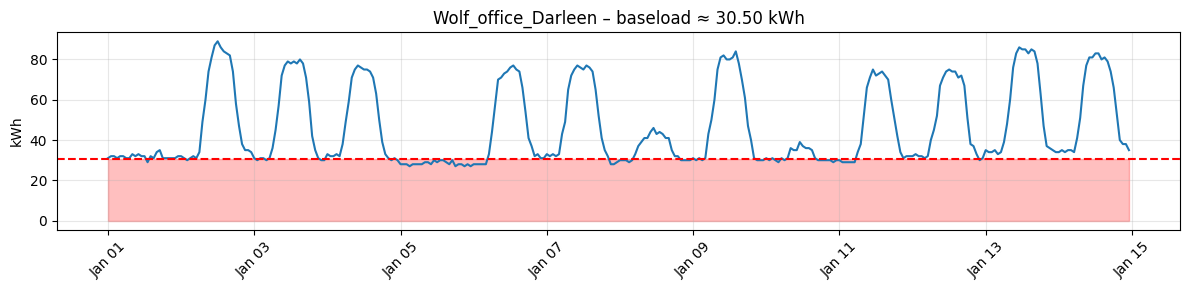

In [26]:
# ------------------------------------------------------------------
# 14‑day plot
# ------------------------------------------------------------------

subset = bldg_hourly.iloc[:24*14]
plt.figure(figsize=(12,3))
plt.plot(subset.index, subset, label='total hourly kWh')
plt.axhline(base_total, color='r', ls='--')
plt.fill_between(subset.index, 0, base_total, color='r', alpha=0.25)
plt.title(f"{bldg} – baseload ≈ {base_total:.2f} kWh")
plt.ylabel('kWh')
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Geospatial Enrichment
Adds latitude/longitude, builds a lightweight `GeoDataFrame`, and engineers time‑of‑use and seasonal features.


In [27]:
loc_info = pd.read_csv("../data/raw/metadata.csv")
loc_info = loc_info[["building_id", "lat", "lng"]]

loc_complete = pd.merge(df_interpolated, loc_info, on="building_id", how="left")

In [28]:
loc_complete.head()

,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature,lat,lng
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.85,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 08:00:00,4.4,37.871903,-122.260729
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.25,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 09:00:00,4.4,37.871903,-122.260729
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.50,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 10:00:00,4.4,37.871903,-122.260729
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.40,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 11:00:00,4.4,37.871903,-122.260729
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.25,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 12:00:00,5.0,37.871903,-122.260729


In [29]:
# Create a GeoDataFrame from your building data
def create_building_gdf(building_df):
    # Create geometry column from lat/long
    geometry = [Point(xy) for xy in zip(building_df['lng'], building_df['lat'])]
    gdf = gpd.GeoDataFrame(building_df, geometry=geometry)
    
    # Set coordinate reference system (CRS)
    gdf.crs = "EPSG:4326"  # WGS84 - standard for GPS coordinates
    return gdf

In [30]:
# Ensure timestamp_local is datetime (only if needed)
if not pd.api.types.is_datetime64_any_dtype(df_interpolated['timestamp_local']):
    df_interpolated['timestamp_local'] = pd.to_datetime(df_interpolated['timestamp_local'])

# Create minimal working features directly on the main DataFrame
df_interpolated['is_weekend'] = df_interpolated['timestamp_local'].dt.dayofweek.isin([5, 6]).astype(int)
df_interpolated['is_working_hours'] = (
    (df_interpolated['timestamp_local'].dt.hour.between(9, 17)) & 
    (~df_interpolated['is_weekend'])
)

# Calculate working hours vs. non-working hours more efficiently
worktime_pivot = (df_interpolated
    .groupby(['building_id', 'is_working_hours'])['meter_reading']
    .mean()
    .unstack()
    .reset_index()
)
worktime_pivot.columns = ['building_id', 'non_working_hours_avg', 'working_hours_avg']

# Get season directly without making a full copy of the dataframe
df_interpolated['season'] = df_interpolated['timestamp_local'].dt.month.map(
    {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
     6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 
     11: 'Fall', 12: 'Winter'}
)

# Calculate seasonal averages more efficiently
seasonal_pivot = (df_interpolated
    .groupby(['building_id', 'season'])['meter_reading']
    .mean()
    .unstack(fill_value=np.nan)
    .reset_index()
)

# First calculate the overall average efficiently
building_avg = df_interpolated.groupby('building_id')['meter_reading'].mean().reset_index()

# IMPORTANT FIX: Create a deduplicated location dataframe with just one row per building
building_locations = loc_complete[['building_id', 'lat', 'lng', 'primaryspaceusage', 'sqm']].drop_duplicates('building_id')
print(f"Reduced from {len(loc_complete):,} rows to {len(building_locations):,} unique buildings")

# Create GeoDataFrame from the much smaller deduplicated dataframe
building_gdf = create_building_gdf(building_locations)

# Now merge with the metrics
building_energy = (building_gdf
    .merge(building_avg, on='building_id')
    .merge(worktime_pivot, on='building_id', how='left')
    .merge(seasonal_pivot, on='building_id', how='left')
)

# Calculate ratio only where both values exist to avoid warnings
building_energy['work_nonwork_ratio'] = (
    building_energy['working_hours_avg'] / 
    building_energy['non_working_hours_avg'].replace(0, np.nan)
)

Reduced from 25,559,768 rows to 1,572 unique buildings


In [31]:
building_energy.head()

,building_id,lat,lng,primaryspaceusage,sqm,geometry,meter_reading,non_working_hours_avg,working_hours_avg,Fall,Spring,Summer,Winter,work_nonwork_ratio
0,Bear_assembly_Angel,37.871903,-122.260729,Entertainment/public assembly,22117.0,POINT (-122.26073 37.8719),493.689969,442.770414,632.896941,512.948114,479.047133,432.054057,527.678661,1.429402
1,Bear_assembly_Beatrice,37.871903,-122.260729,Entertainment/public assembly,2802.0,POINT (-122.26073 37.8719),42.967896,41.011989,48.329225,45.903064,43.937069,39.980303,42.069739,1.178417
2,Bear_assembly_Danial,37.871903,-122.260729,Entertainment/public assembly,7680.3,POINT (-122.26073 37.8719),160.795306,150.840653,188.050357,167.952140,155.603627,172.165492,143.235159,1.246682
3,Bear_assembly_Diana,37.871903,-122.260729,Entertainment/public assembly,121.2,POINT (-122.26073 37.8719),0.860259,0.709134,1.274035,0.857386,0.898230,0.824236,0.870886,1.796606
4,Bear_assembly_Genia,37.871903,-122.260729,Entertainment/public assembly,24256.1,POINT (-122.26073 37.8719),263.332892,256.451132,282.196455,321.115094,248.013152,237.994462,246.590114,1.100391


In [32]:
# Identify buildings with missing lat/lng values
buildings_with_missing_coords = building_energy[
    building_energy['lat'].isna() | building_energy['lng'].isna()
]['building_id'].unique()

print(f"Found {len(buildings_with_missing_coords)} buildings with missing coordinates")
print(buildings_with_missing_coords[:10])  # Show first few for inspection

Found 232 buildings with missing coordinates
['Bobcat_assembly_Adam' 'Bobcat_assembly_Billy' 'Bobcat_assembly_Camilla'
 'Bobcat_assembly_Franklin' 'Bobcat_education_Alissa'
 'Bobcat_education_Angela' 'Bobcat_education_Barbra'
 'Bobcat_education_Coleman' 'Bobcat_education_Dylan'
 'Bobcat_education_Emile']


## Interactive Energy Map • `create_modern_building_energy_map()`
Generates a Folium map with clustered markers, seasonal layer toggles, and a minimalist legend.


In [ ]:
def create_building_energy_map(building_energy_df):
    """
    Create a modern, minimalist energy map with proper clustering and detailed zoom views.
    """
    # Create a clean dataset with one row per building, removing missing coordinates
    building_summary = building_energy_df.drop_duplicates(subset=['building_id'])
    building_summary = building_summary[
        building_summary['lat'].notna() & 
        building_summary['lng'].notna() & 
        building_summary['meter_reading'].notna()
    ]
    
    print(f"Mapping {len(building_summary)} buildings with valid coordinates")
    
    # Calculate center point for initial view
    center_lat = building_summary['lat'].mean()
    center_lon = building_summary['lng'].mean()
    
    # Create base map with cleaner styling
    m = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=10, 
        tiles="CartoDB positron",
        control_scale=True
    )
    
    # Create seasonal energy layer groups
    all_seasons = folium.FeatureGroup(name="All Seasons (Average)")
    winter_group = folium.FeatureGroup(name="Winter Energy")
    spring_group = folium.FeatureGroup(name="Spring Energy")
    summer_group = folium.FeatureGroup(name="Summer Energy")
    fall_group = folium.FeatureGroup(name="Fall Energy")
    
    # Create marker clusters for each season - the key to good zooming behavior
    all_cluster = MarkerCluster(
        name="All Buildings",
        overlay=True,
        control=False,
        options={
            'disableClusteringAtZoom': 15,
            'maxClusterRadius': 35,
            'spiderfyOnMaxZoom': False
        }
    ).add_to(all_seasons)
    
    winter_cluster = MarkerCluster(name="Winter", overlay=True, control=False).add_to(winter_group)
    spring_cluster = MarkerCluster(name="Spring", overlay=True, control=False).add_to(spring_group)
    summer_cluster = MarkerCluster(name="Summer", overlay=True, control=False).add_to(summer_group)
    fall_cluster = MarkerCluster(name="Fall", overlay=True, control=False).add_to(fall_group)
    
    # Define a modern color palette
    def get_color_modern(value, thresholds):
        if pd.isna(value):
            return '#9e9e9e'  # Gray for missing data
        if value <= thresholds['q25']:
            return '#2ecc71'  # Fresh green
        elif value <= thresholds['q50']:
            return '#f1c40f'  # Gold/yellow
        elif value <= thresholds['q75']:
            return '#e67e22'  # Orange
        else:
            return '#e74c3c'  # Red
        
    # Calculate thresholds for color coding
    thresholds = {
        'avg': {
            'q25': building_summary['meter_reading'].quantile(0.25),
            'q50': building_summary['meter_reading'].quantile(0.50),
            'q75': building_summary['meter_reading'].quantile(0.75)
        }
    }
    
    # Calculate seasonal thresholds
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        if season in building_summary.columns:
            thresholds[season] = {
                'q25': building_summary[season].dropna().quantile(0.25),
                'q50': building_summary[season].dropna().quantile(0.50),
                'q75': building_summary[season].dropna().quantile(0.75)
            }
    
    # Add buildings to the map with improved styling
    for _, row in building_summary.iterrows():
        # Average energy markers
        avg_energy = row['meter_reading']
        color = get_color_modern(avg_energy, thresholds['avg'])
        
        # Determine size based on energy (but keep it reasonable)
        size = min(10, max(5, 5 + (avg_energy / thresholds['avg']['q75']) * 5))
        
        # Format seasonal values properly
        winter_value = f"{row.get('Winter'):.1f}" if pd.notna(row.get('Winter')) else "N/A"
        spring_value = f"{row.get('Spring'):.1f}" if pd.notna(row.get('Spring')) else "N/A"
        summer_value = f"{row.get('Summer'):.1f}" if pd.notna(row.get('Summer')) else "N/A"
        fall_value = f"{row.get('Fall'):.1f}" if pd.notna(row.get('Fall')) else "N/A"
        
        # Create a clean, modern popup with all relevant data
        popup_html = f"""
        <div style="font-family: 'Segoe UI', Arial, sans-serif; width: 200px;">
            <h4 style="margin-bottom: 10px; border-bottom: 2px solid {color};">{row['building_id']}</h4>
            <p><strong>Type:</strong> {row.get('primaryspaceusage', 'Unknown')}</p>
            <p><strong>Average Energy:</strong> {avg_energy:.1f} kWh</p>
            <p><strong>Area:</strong> {row.get('sqm', 'N/A')} sqm</p>
            
            <div style="margin-top: 10px; font-size: 0.9em;">
                <p><strong>Seasonal Usage:</strong></p>
                <table style="width: 100%; border-collapse: collapse;">
                    <tr>
                        <td>Winter:</td><td>{winter_value} kWh</td>
                    </tr>
                    <tr>
                        <td>Spring:</td><td>{spring_value} kWh</td>
                    </tr>
                    <tr>
                        <td>Summer:</td><td>{summer_value} kWh</td>
                    </tr>
                    <tr>
                        <td>Fall:</td><td>{fall_value} kWh</td>
                    </tr>
                </table>
            </div>
        </div>
        """
        
        # Add marker to all_seasons cluster
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=size,
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=folium.Popup(folium.Html(popup_html, script=True), max_width=250),
            tooltip=f"{row['building_id']}: {avg_energy:.1f} kWh"
        ).add_to(all_cluster)
        
        # Add seasonal markers to their respective clusters
        for season, cluster, season_value in [
            ('Winter', winter_cluster, winter_value),
            ('Spring', spring_cluster, spring_value),
            ('Summer', summer_cluster, summer_value),
            ('Fall', fall_cluster, fall_value)
        ]:
            if season in row and pd.notna(row[season]):
                seasonal_color = get_color_modern(row[season], thresholds.get(season, thresholds['avg']))
                seasonal_size = min(10, max(5, 5 + (row[season] / thresholds[season]['q75']) * 5))
                
                folium.CircleMarker(
                    location=[row['lat'], row['lng']],
                    radius=seasonal_size,
                    color='black',
                    weight=1,
                    fill=True,
                    fill_color=seasonal_color,
                    fill_opacity=0.8,
                    popup=folium.Popup(folium.Html(popup_html, script=True), max_width=250),
                    tooltip=f"{row['building_id']}: {season} - {row[season]:.1f} kWh"
                ).add_to(cluster)
    
    # Add all feature groups to map
    all_seasons.add_to(m)
    winter_group.add_to(m)
    spring_group.add_to(m)
    summer_group.add_to(m)
    fall_group.add_to(m)
    
    # Add modern, clean legend
    legend_html = """
    <div style="position: fixed; bottom: 20px; left: 20px; z-index: 1000; 
         background-color: white; padding: 12px; border-radius: 6px; 
         box-shadow: 0 1px 5px rgba(0,0,0,0.2); font-family: 'Segoe UI', Arial, sans-serif; max-width: 180px;">
        <div style="font-weight: bold; margin-bottom: 10px; font-size: 14px; border-bottom: 1px solid #eee; padding-bottom: 5px;">ENERGY USAGE</div>
        
        <div style="display: flex; align-items: center; margin-bottom: 6px;">
            <span style="background-color: #2ecc71; width: 14px; height: 14px; display: inline-block; margin-right: 8px; border-radius: 50%;"></span>
            <span style="font-size: 12px;">Low (0-25%)</span>
        </div>
        <div style="display: flex; align-items: center; margin-bottom: 6px;">
            <span style="background-color: #f1c40f; width: 14px; height: 14px; display: inline-block; margin-right: 8px; border-radius: 50%;"></span>
            <span style="font-size: 12px;">Medium-Low (25-50%)</span>
        </div>
        <div style="display: flex; align-items: center; margin-bottom: 6px;">
            <span style="background-color: #e67e22; width: 14px; height: 14px; display: inline-block; margin-right: 8px; border-radius: 50%;"></span>
            <span style="font-size: 12px;">Medium-High (50-75%)</span>
        </div>
        <div style="display: flex; align-items: center;">
            <span style="background-color: #e74c3c; width: 14px; height: 14px; display: inline-block; margin-right: 8px; border-radius: 50%;"></span>
            <span style="font-size: 12px;">High (75-100%)</span>
        </div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control with clean styling
    folium.LayerControl(position='topright', collapsed=False).add_to(m)
    
    # Add fullscreen control
    folium.plugins.Fullscreen(
        position='topleft',
        title='Fullscreen',
        title_cancel='Exit'
    ).add_to(m)
    
    # Add searching capability
    folium.plugins.Geocoder(position='topleft').add_to(m)

    # Add custom JavaScript to implement radio-button style behavior for seasonal layers
    radio_button_js = """
    <script>
    // Wait for the map and controls to be fully loaded
    document.addEventListener('DOMContentLoaded', (event) => {
        setTimeout(function() {
            // Get all layer control inputs
            var seasonalLayers = ['Winter Energy', 'Spring Energy', 'Summer Energy', 'Fall Energy'];
            var checkboxes = document.querySelectorAll('.leaflet-control-layers-selector');
            
            // Add click event listeners
            checkboxes.forEach(function(checkbox) {
                checkbox.addEventListener('change', function(e) {
                    // Get the layer name from the label text
                    var layerName = this.nextSibling.textContent.trim();
                    
                    // If this is a seasonal layer that was just checked
                    if (seasonalLayers.includes(layerName) && this.checked) {
                        // Uncheck all other seasonal layers
                        checkboxes.forEach(function(otherCheckbox) {
                            var otherLayerName = otherCheckbox.nextSibling.textContent.trim();
                            if (seasonalLayers.includes(otherLayerName) && otherLayerName !== layerName) {
                                if (otherCheckbox.checked) {
                                    otherCheckbox.click();
                                }
                            }
                        });
                    }
                });
            });
        }, 1000); // Small delay to ensure controls are fully loaded
    });
    </script>
    """

    # Add the custom JavaScript to the map
    m.get_root().html.add_child(folium.Element(radio_button_js))

    # Add a note about seasonal filters (optional)
    filter_info_html = """
    <div style="position: fixed; bottom: 160px; left: 20px; z-index: 1000; 
        background-color: white; padding: 10px; border-radius: 6px; 
        box-shadow: 0 1px 5px rgba(0,0,0,0.2); font-family: 'Segoe UI', Arial, sans-serif;">
        <div style="font-size: 12px;">
            <strong>Tip:</strong> Only one season can be viewed at a time.
        </div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(filter_info_html))
    
    return m

In [ ]:
# Create the map using your building_energy DataFrame
m = create_building_energy_map(building_energy)

# Save to HTML file
m.save('building_energy_map.html')
print("Map saved successfully! Open the HTML file to view it.")

Mapping 1340 buildings with valid coordinates
Map saved successfully! Open the HTML file to view it.
